# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Dandi

Last Name: Peng

Student ID: 915553480

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [1]:
import sqlite3 as sql
import pandas as pd

In [2]:
db = sql.connect('sf_data.sqlite')
db.row_factory = sql.Row

In [3]:
# INNER JOIN mobile_food_permits where Status is "APPROVED" with mobile_food_schedule 
scd_most = db.execute('''SELECT count(permit), permit, Applicant FROM 
                        (SELECT * FROM (SELECT l.Applicant, r.* FROM mobile_food_permits AS l 
                        INNER JOIN mobile_food_schedule AS r ON l.permit = r.permit WHERE l.Status = 'APPROVED')
                        GROUP BY locationid, permit) 
                        GROUP BY permit ORDER BY count(permit) DESC''')

In [4]:
scd_most_rows = scd_most.fetchall()

In [5]:
scd_most_rows[0]['Applicant']

"Park's Catering"

In [6]:
scd_most_rows[0]['count(permit)']

23

__Answer:__

Counting upon all food vendors with Status is "APPROVED", __`Park's Catering`__ sells at the most locations, the number of which is 23.

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
import osmnx as ox 
import shapely.geometry as geom

In [8]:
# get the San Francisco Neighborhoods
ngbrs = gpd.read_file('geo_export_29d5482b-a1c4-499a-bba7-0e76e905b83a.shp')
ngbrs.head()

link                    name  \
0  http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...                Seacliff   
1                                               None             Lake Street   
2                  http://www.nps.gov/prsf/index.htm  Presidio National Park   
3                                               None        Presidio Terrace   
4  http://www.sfgate.com/neighborhoods/sf/innerri...          Inner Richmond   

                                            geometry  
0  POLYGON ((-122.4934552679999 37.78351817100008...  
1  POLYGON ((-122.4871507149999 37.78378542700005...  
2  POLYGON ((-122.4775801709999 37.81099311300005...  
3  POLYGON ((-122.4724105299999 37.78734653900005...  
4  POLYGON ((-122.4726257899999 37.78631480600006...

In [10]:
# get the postcode geopanda dataframe
postcode = gpd.read_file("cb_2016_us_zcta510_500k.shp")

# change the type of 'GEOID10' in postcode table for following table merge
postcode["GEOID10"] = postcode["GEOID10"].astype('int64')
postcode.head()

ZCTA5CE10      AFFGEOID10  GEOID10    ALAND10  AWATER10  \
0     21914  8600000US21914    21914    1924479    477175   
1     01001  8600000US01001     1001   29731610   2118827   
2     34736  8600000US34736    34736  322808220  78588518   
3     46151  8600000US46151    46151  530632048   9804480   
4     48039  8600000US48039    48039   59592687   4845242   

                                            geometry  
0  POLYGON ((-75.99444799999999 39.567742, -75.99...  
1  POLYGON ((-72.667677 42.045022, -72.657715 42....  
2  (POLYGON ((-81.806163 28.568643, -81.801577999...  
3  (POLYGON ((-86.398562 39.320829, -86.398125999...  
4  POLYGON ((-82.61060000000001 42.724669, -82.51...

__Which parts of the city are the most and least expensive?__

In [11]:
zillow = pd.read_sql('SELECT RegionName, MedianSoldPricePerSqft_AllHomes FROM zillow',db)
zillow = zillow.dropna(axis=0, how='any').reset_index(drop=True)

# get the mean MedianSoldPrice of different regions
zillow_gp_pc = zillow.groupby("RegionName", as_index=False).mean()

# sort the MedianSoldPrice
zillow_gp_pc = zillow_gp_pc.sort_values(by=['MedianSoldPricePerSqft_AllHomes'], 
                                        axis=0, ascending=False).reset_index(drop = True)

# Change the column name of zillow for the following merge table
zillow_gp_pc.rename(columns={'RegionName': 'GEOID10'}, inplace=True)

# convert to GeoDataFrame zillow_gpd
zillow_gpd = gpd.GeoDataFrame(zillow_gp_pc)

# merge zillow_gpd with postcode to prepare for map
zillow_gpd = zillow_gpd.merge(postcode, on='GEOID10')
zillow_gpd.head()

GEOID10  MedianSoldPricePerSqft_AllHomes ZCTA5CE10      AFFGEOID10  \
0    94104                      1336.128581     94104  8600000US94104   
1    94105                       798.257824     94105  8600000US94105   
2    94123                       696.166788     94123  8600000US94123   
3    94158                       657.211820     94158  8600000US94158   
4    94114                       650.127729     94114  8600000US94114   

   ALAND10  AWATER10                                           geometry  
0   200857         0  POLYGON ((-122.404613 37.793565, -122.401315 3...  
1   952915    208000  POLYGON ((-122.403456 37.787776, -122.401939 3...  
2  2651010    218721  (POLYGON ((-122.450323 37.803584, -122.44829 3...  
3  1703879   1342698  POLYGON ((-122.397866 37.772323, -122.396381 3...  
4  3692444         0  POLYGON ((-122.454002 37.758785, -122.451817 3...

In [12]:
zillow_expensive = zillow_gpd.head(5)
zillow_cheap = zillow_gpd.tail(5)

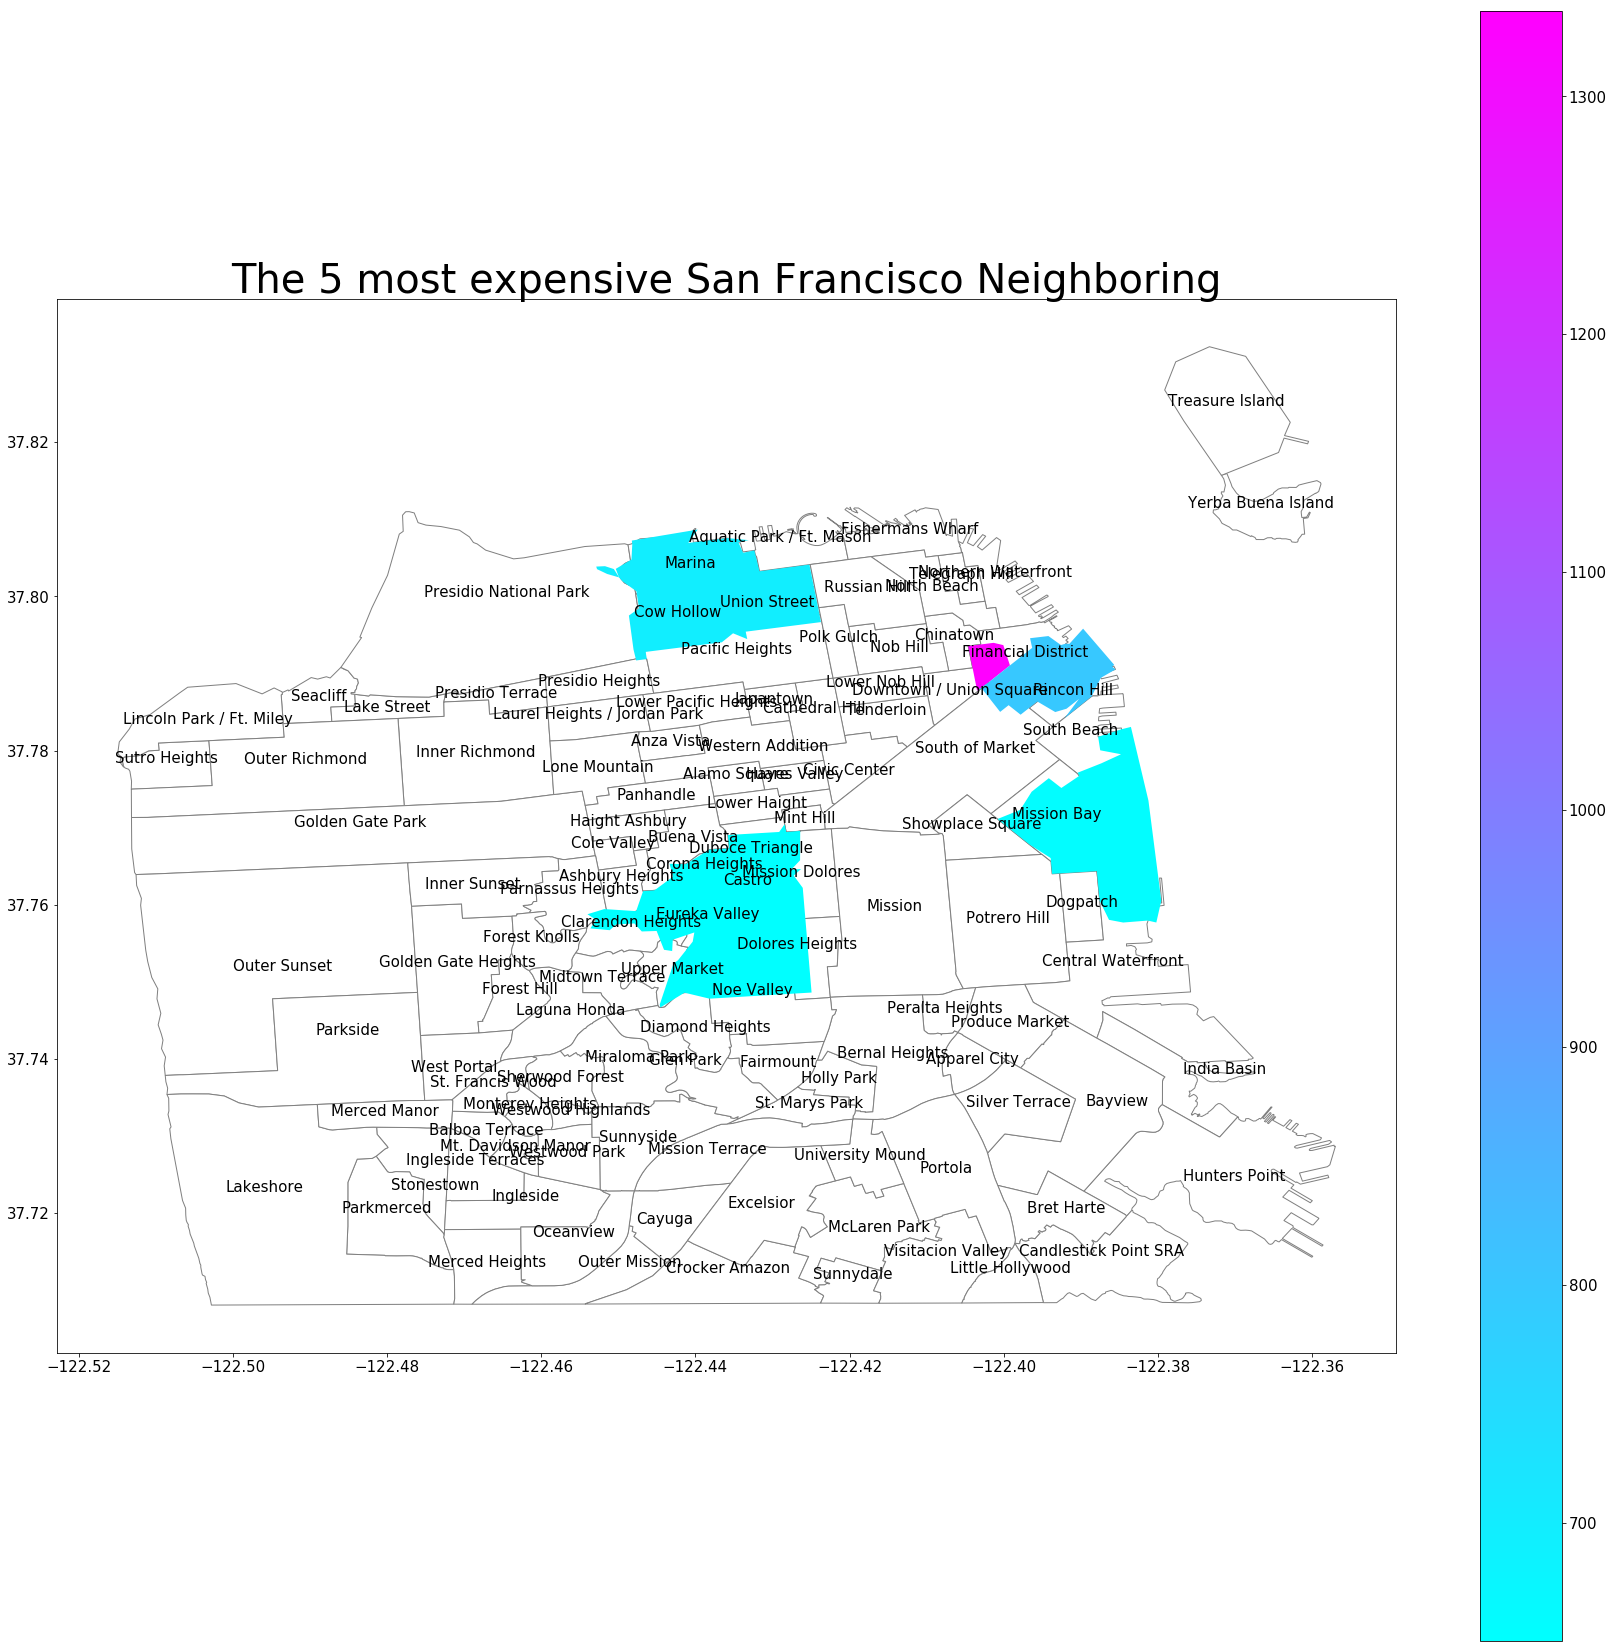

In [13]:
matplotlib.rcParams.update({'font.size': 15})

ax = ngbrs.plot(figsize=(30,30), edgecolor = "gray", color = "white")
#ax.grid(color='light', alpha=0.7)
zillow_expensive.plot(ax = ax, column = "MedianSoldPricePerSqft_AllHomes", 
                      cmap='cool', markersize=3, legend = True)

# Set x and y limits to adjust the "zoom".
#ax.set_xlim([-122.5, -122.35])
#ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row['name'], xy = coords, horizontalalignment = "center")
    
# Call add_label() on each row.
ngbrs.apply(add_label, axis = 1)

plt.title("The 5 most expensive San Francisco Neighboring", fontsize = 40)
plt.show()

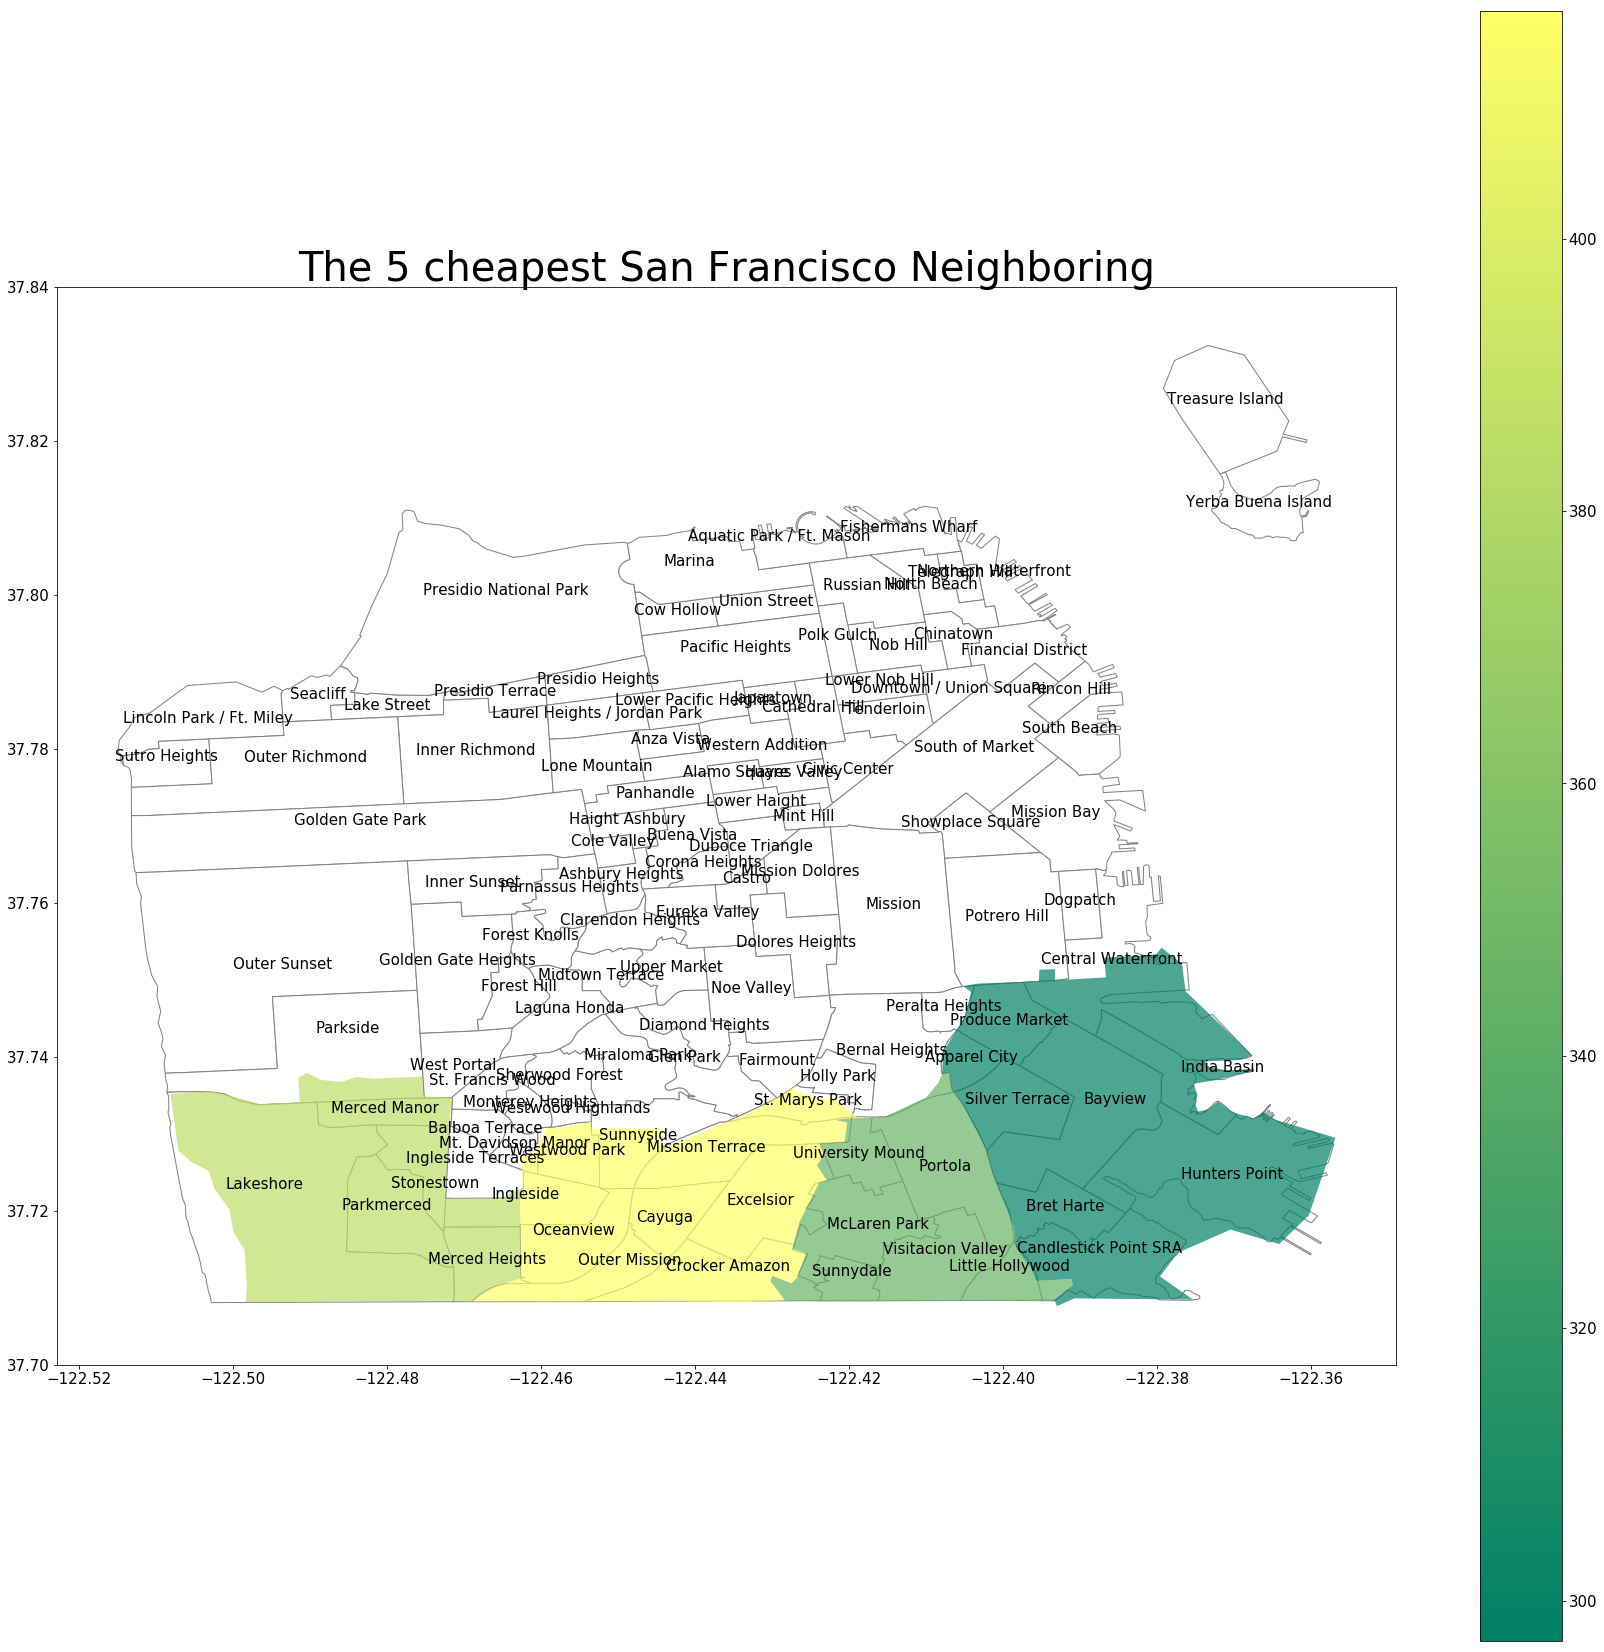

In [14]:
ax = ngbrs.plot(figsize=(30,30), edgecolor = "gray", color = "white")
zillow_cheap.plot(ax = ax, column = "MedianSoldPricePerSqft_AllHomes", 
                  cmap = "summer", markersize=3, alpha=0.7, legend = True)

# Set x and y limits to adjust the "zoom".
#ax.set_xlim([-122.5, -122.35])
ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row['name'], xy = coords, horizontalalignment = "center")
    
# Call add_label() on each row.
ngbrs.apply(add_label, axis = 1)

plt.title("The 5 cheapest San Francisco Neighboring", fontsize = 40)
plt.show()

__Answer:__

__`The 5 most expensive San Francisco Neighboring` map__

It is very obvious for us to find out that that the most expensive San Francisco Neighborhood is Financial District. 

The Financial District is the city's business center, home to the city's largest concentration of corporate headquarters, law firms, insurance companies, real estate firms, banks, savings and loans, and other financial institutions. 

Therefore, _`it is reasonable that it is the most expensive place which has an apparent difference with the second expensive one -`_ __"Rincon Hill"__ _`as well`_.

Rincon Hill was destroyed by the 1906 earthquake and fire, then was slowly rezoned into a high-density residential neighborhood designed to house up to 10,000 new residents in close proximity to the city's _Financial District_. In my opinion, that's the main reason for its high housing price.

__`The 5 cheapest San Francisco Neighboring` map__

The cheapest neighboring is the southeastern corner in the map, which mainly includes `Sliver Terrac&ayview`, `Hunters Point`, etc.

A redevelopment project called Hunters Point Shipyard, which has been criticized for a long time, probably is one of the reasons for cheap housing price. Criticism of the project focused on the large-scale toxic clean-up of the industrial superfund site, environmental impact of waterfront construction, displacement of an impoverished neighborhood populace and a required build-up to solve transportation needs.

__Which parts of the city are the most dangerous (and at what times)?__

In [16]:
crime = pd.read_sql('SELECT * FROM crime', db)
crime_lonlat = [geom.Point(x) for x in zip(crime.Lon, crime.Lat)]
crime = gpd.GeoDataFrame(crime, geometry = crime_lonlat)
crime.head(2)

IncidntNum      Category               Descript DayOfWeek  \
0   150060275  NON-CRIMINAL          LOST PROPERTY    Monday   
1   150098210       ROBBERY  ROBBERY, BODILY FORCE    Sunday   

              Datetime  PdDistrict Resolution                      Address  \
0  2015-01-19 14:00:00     MISSION       NONE        18TH ST / VALENCIA ST   
1  2015-02-01 15:45:00  TENDERLOIN       NONE  300 Block of LEAVENWORTH ST   

          Lon        Lat                                    geometry  
0 -122.421582  37.761701   POINT (-122.42158168137 37.7617007179518)  
1 -122.414406  37.784191  POINT (-122.414406029855 37.7841907151119)

In [17]:
crime_dist = crime.groupby(by = 'PdDistrict',as_index=False).sum()
crime_dist = crime_dist.sort_values('IncidntNum',ascending=False).reset_index(drop = True)
crime_dist.head(2)

PdDistrict      IncidntNum           Lon           Lat
0   SOUTHERN  26198128934284 -2.401320e+07  7.411571e+06
1    MISSION  18014825485570 -1.667552e+07  5.143544e+06

In [18]:
for i in crime_dist['PdDistrict']:
    exec('crime_' + i + ' = crime.loc[crime["PdDistrict"] == i]')

In [19]:
c = []
for i in crime_dist['PdDistrict']:
    c.append(i)
color = ['red', 'darkorange', 'yellow', 'olive', 'forestgreen', 'mediumturquoise',
        'dodgerblue','mediumblue', 'mediumpurple', 'purple']

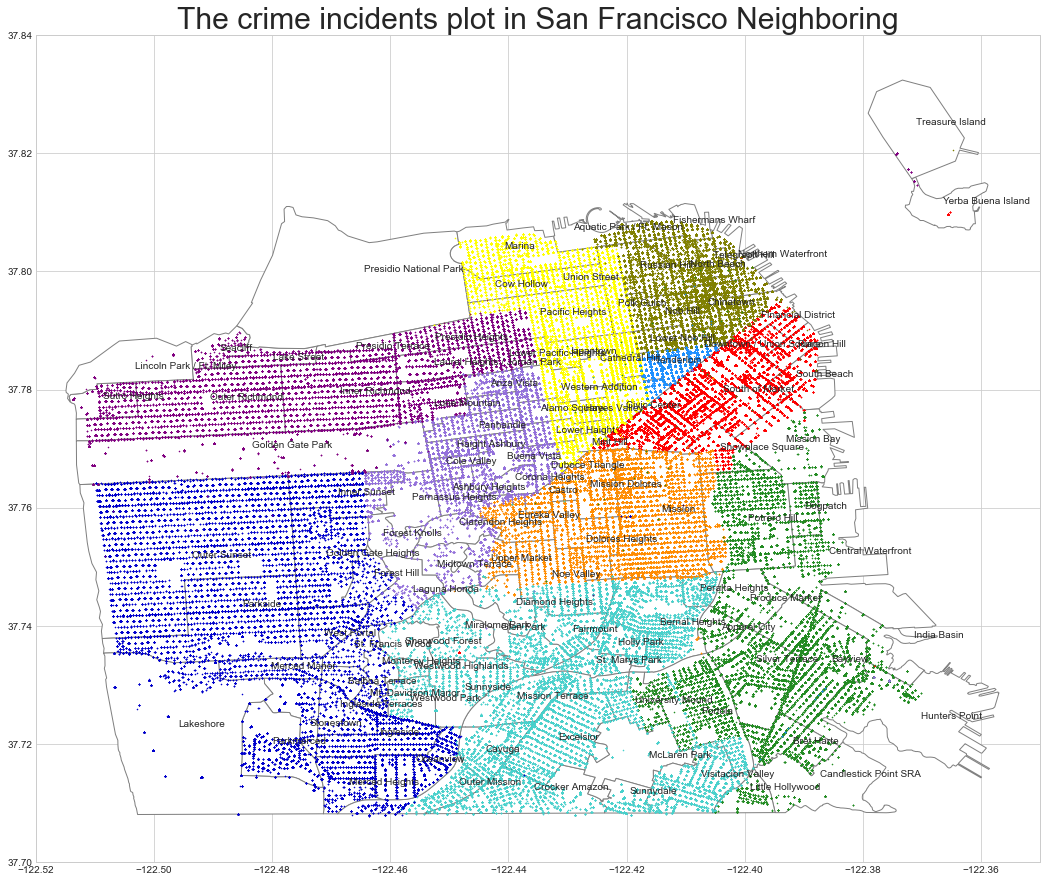

In [23]:
matplotlib.rcParams.update({'font.size': 10})

ax = ngbrs.plot(figsize = (18, 18), edgecolor = "gray", color = "white")

for i,j in zip(c, color):
    exec('crime_' + i + '.plot(ax = ax, marker="*", c="'+j+'", markersize=0.5, legend = True)')

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row['name'], xy = coords, horizontalalignment = "left")
    
# Call add_label() on each row.
ngbrs.apply(add_label, axis = 1)


plt.title("The crime incidents plot in San Francisco Neighboring", fontsize = 30)
plt.show()

In [21]:
# get the table counting number of crime incidents for each hour in a day
crime_time = pd.read_sql("""
SELECT strftime('%H',Datetime) AS hour_time, Count(*) FROM crime
GROUP BY hour_time ORDER BY count(*) DESC
""",db)

crime_time.rename(columns={'Count(*)': 'Number_of_Incidents'}, inplace=True)
crime_time.head(2)

hour_time  Number_of_Incidents
0        18                66665
1        17                63724

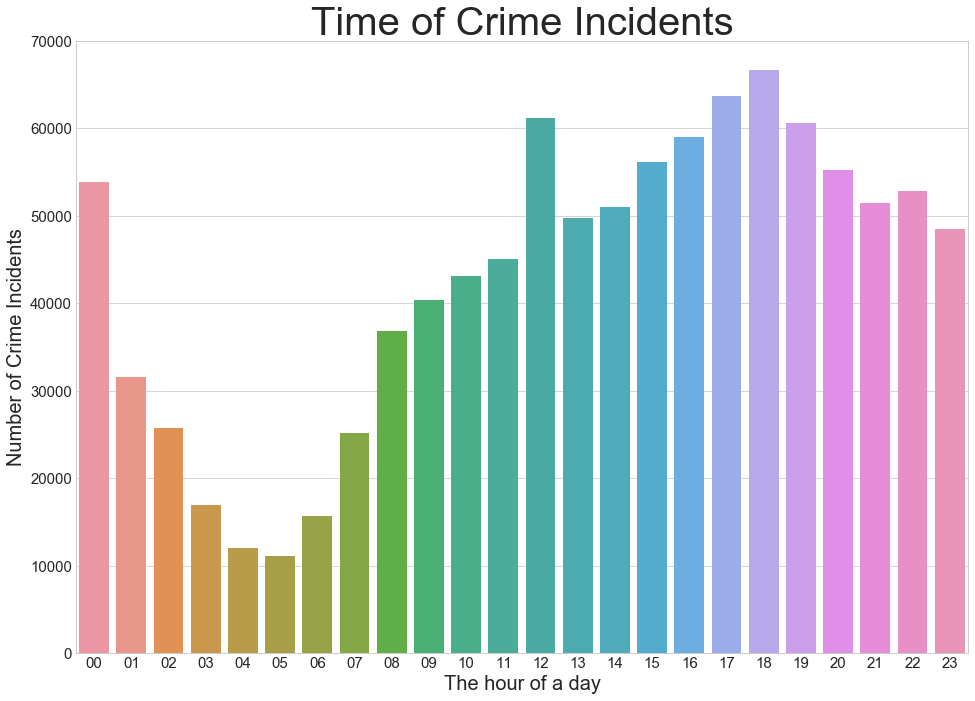

In [22]:
# Plot the time

import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(16, 11.27)
plot=sns.barplot(x='hour_time', y='Number_of_Incidents', data=crime_time)
plot.axes.set_title("Time of Crime Incidents",fontsize=40)
plot.set_xlabel("The hour of a day",fontsize=20)
plot.set_ylabel("Number of Crime Incidents",fontsize=20)
plot.tick_params(labelsize=15)

__Answer:__

* _Most Dangerous Part of the city_:

From the above __`The crime incidents plot in San Francisco Neighboring`__, we can capture that huge number of points plot on the northeastern corner of San Francisco. 

Several neighborings, such as Russian Hill known for Lombard Street, North Beach, Chinatown and Nob Hill, are extremely popular tourist areas. This probably is the reason for high crime rates.

There are also several neighborings in the middle part of San Francisco look like dangerous as well. Lower Haight, for example, is characterized by a mixture of restaurants, small nightclubs, cafes, drinking establishments, residences, galleries, and hair salons, which differs from Upper Haight by having a more diverse population. Although the crime rate here has gradually been reduced with a series of measures as a public nuisance lawsuit, a moratorium and so on, based on the crime records, we are still not able to say "this is a safe place".

* _Most Dangerous Time in the city_:

Upon the above __`Time of Crime Incidents`__ bar plot, the top three most dangerous times are from 18:00 to 19:00, from 17:00 to 18:00 and from 12:00 to 13:00.

17:00 to 19:00 is the time around sunset. Workers going back home are more likely to be tired and off guard, also near-dark environment probably enourages crimes.

__Are noise complaints and mobile food vendors related?__

In [24]:
f_sch = pd.read_sql('SELECT * FROM mobile_food_schedule',db)
f_loc = pd.read_sql('SELECT * FROM mobile_food_locations',db)

In [25]:
f_loc_lonlat = [geom.Point(x) for x in zip(f_loc.Longitude, f_loc.Latitude)]
f_loc = gpd.GeoDataFrame(f_loc, geometry = f_loc_lonlat)
f_loc.head(2)

locationid                            LocationDescription          Address  \
0      762182    TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)  444 TOWNSEND ST   
1      437211  MISSOURI ST: 20TH ST to SIERRA ST (500 - 630)  555 MISSOURI ST   

    Latitude   Longitude                                    geometry  
0  37.774871 -122.398532  POINT (-122.398531708276 37.7748713162388)  
1  37.759304 -122.395902  POINT (-122.395902231236 37.7593037663834)

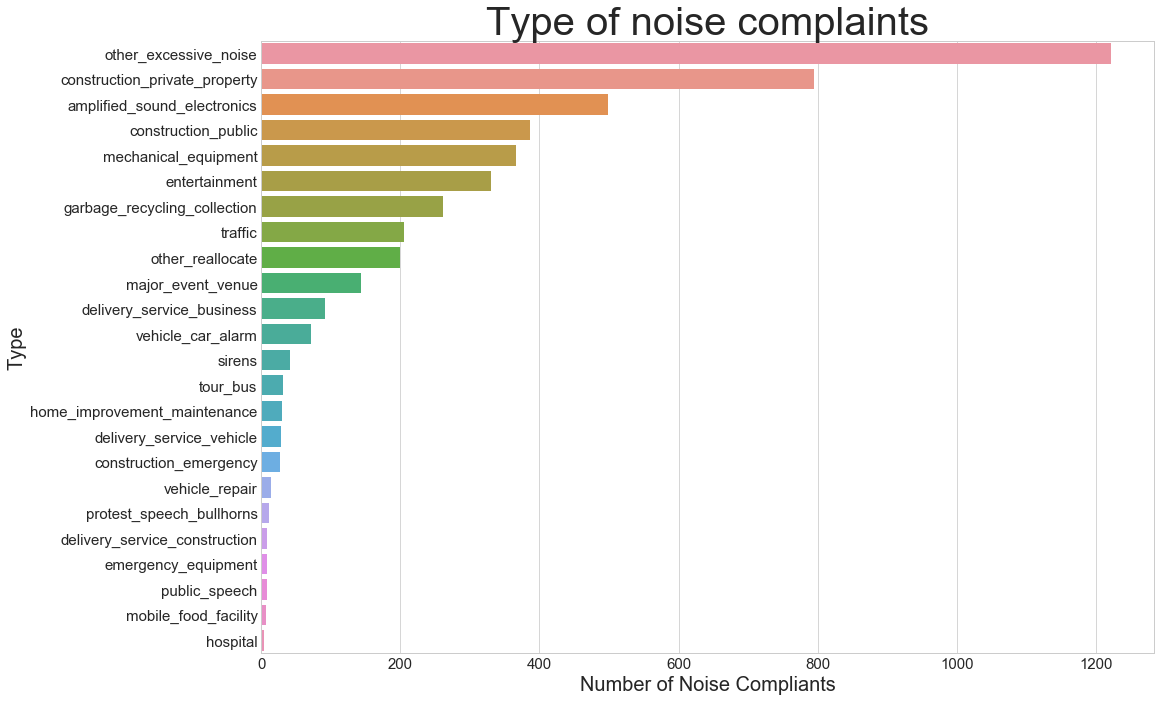

In [26]:
noise_type = pd.read_sql('SELECT *, count(*) FROM noise GROUP BY Type ORDER BY count(*) DESC', db)

sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(16, 11.27)
plot=sns.barplot(x='count(*)', y='Type', data=noise_type)
plot.axes.set_title("Type of noise complaints",fontsize=40)
plot.set_ylabel("Type",fontsize=20)
plot.set_xlabel("Number of Noise Compliants",fontsize=20)
plot.tick_params(labelsize=15)

In [27]:
noise = pd.read_sql('SELECT * FROM noise', db)
noise_lonlat = [geom.Point(x) for x in zip(noise.Lon, noise.Lat)]
noise = gpd.GeoDataFrame(noise, geometry = noise_lonlat)
noise.head(2)

CaseID                         Type  \
0  5130305        other_excessive_noise   
1  6446138  amplified_sound_electronics   

                                        Address     Neighborhood  \
0        Not associated with a specific address             None   
1  Intersection of CLINTON PARK and GUERRERO ST  Mission Dolores   

              Datetime        Lat         Lon  \
0  2015-09-25 00:29:33        NaN         NaN   
1  2016-10-21 13:20:18  37.769148 -122.424475   

                                     geometry  
0                             POINT (nan nan)  
1  POINT (-122.424474850717 37.7691482064722)

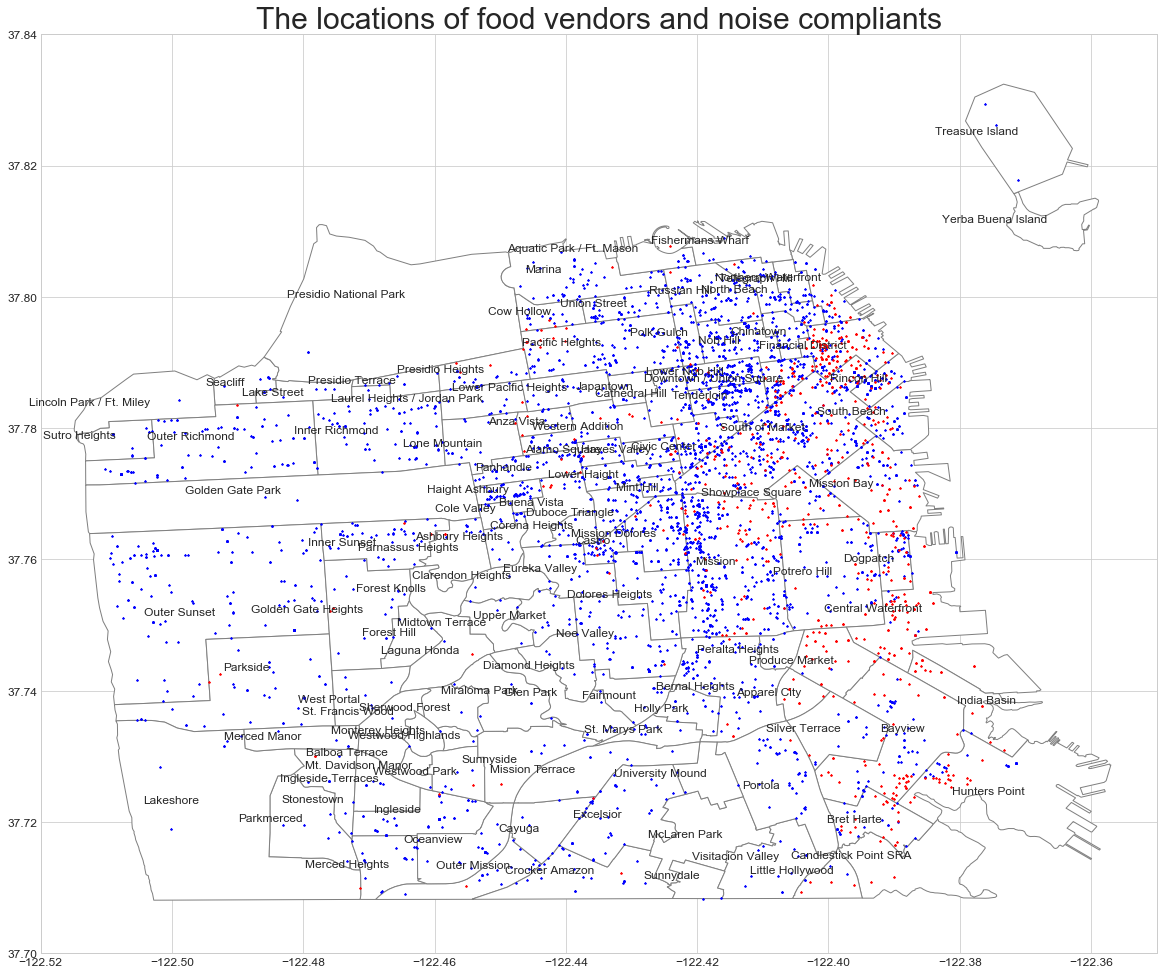

In [28]:
#matplotlib.rcParams.update({'font.size': 12,'font.weight': 'bold'})
matplotlib.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

ax = ngbrs.plot(figsize = (20,30), edgecolor = "gray", color = "white")
noise.plot(ax = ax, marker='*', color='blue', markersize=3)
f_loc.plot(ax = ax, marker='*', color='red', markersize=3)

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row["name"], xy = coords, horizontalalignment = "right")
        
# Call add_label() on each row.
ngbrs.apply(add_label, axis = 1)

plt.title("The locations of food vendors and noise compliants", fontsize = 30)
plt.show()

__Answer:__

While the blue points indicate the noise complaints and the red points tell us the locations of food vendors, in the east, mostly northeast part of San Francisco, there are some overlaps among them.

Most noise complaint cases are around the northeast of San Francisco, in other words, where lots of tourists would like to visit. By checking the type of noise complaints, however, the top several cases are more related to construction and entertainment.

Therefore, we can conclude that the noise may be related with the food vendors somehow, but mostly food vendors are not the one that should be blamed for.

__What are the best times and places to find food trucks?__

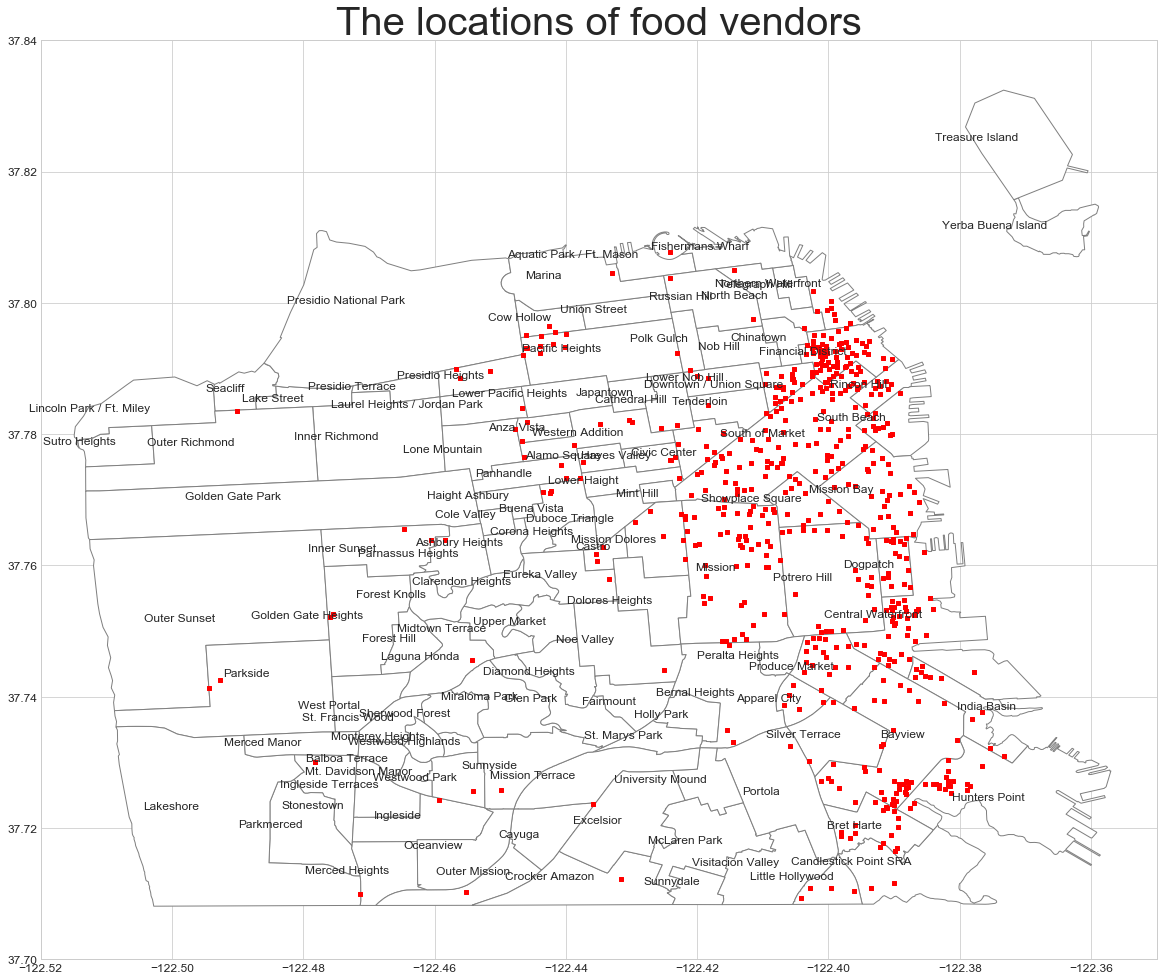

In [29]:
matplotlib.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

ax = ngbrs.plot(figsize = (20,30), edgecolor = "gray", color = "white")

f_loc.plot(ax = ax, marker=',', color='red', markersize=10)

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row["name"], xy = coords, horizontalalignment = "right")
        
# Call add_label() on each row.
ngbrs.apply(add_label, axis = 1)

plt.title("The locations of food vendors", fontsize = 40)
plt.show()

In [32]:
# best time in a day
fd_time = pd.read_sql("""
SELECT count(*),* FROM mobile_food_schedule 
GROUP BY StartHour, EndHour ORDER BY count(*) DESC
""", db)

fd_time.rename(columns={'count(*)': 'Number of food vendors'}, inplace=True)
fd_time.head(2)

Number of food vendors  locationid      permit DayOfWeek  EndHour  \
0                     534      936620  17MFF-0125        Fr       10   
1                     443      936623  17MFF-0125        Fr       11   

   StartHour  
0          9  
1         10

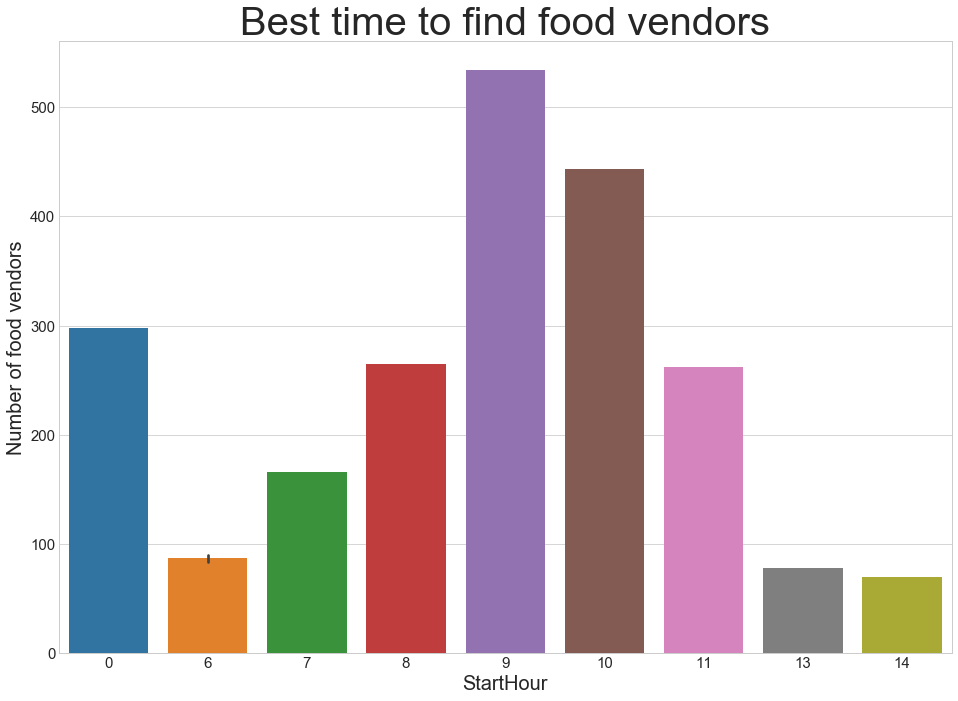

In [33]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(16, 11.27)
plot=sns.barplot(x='StartHour', y='Number of food vendors', data=fd_time.head(10))
plot.axes.set_title("Best time to find food vendors",fontsize=40)
plot.set_ylabel("Number of food vendors",fontsize=20)
plot.set_xlabel("StartHour",fontsize=20)
plot.tick_params(labelsize=15)

In [34]:
# best time in the day of a week
fd_day = pd.read_sql("""
SELECT count(*),* FROM mobile_food_schedule 
GROUP BY DayOfWeek ORDER BY count(*) DESC
""", db)

fd_day.rename(columns={'count(*)': 'Number of food vendors'}, inplace=True)

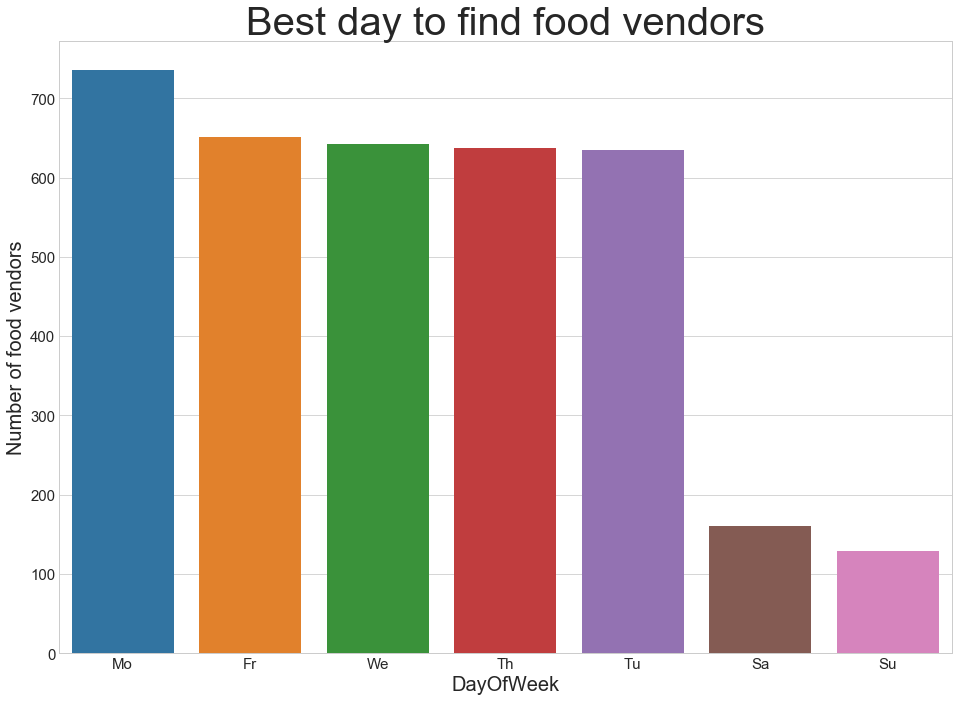

In [35]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(16, 11.27)
plot=sns.barplot(x='DayOfWeek', y='Number of food vendors', data=fd_day)
plot.axes.set_title("Best day to find food vendors",fontsize=40)
plot.set_ylabel("Number of food vendors",fontsize=20)
plot.set_xlabel("DayOfWeek",fontsize=20)
plot.tick_params(labelsize=15)

__Answer:__

Upon the __`The locations of food vendors`__ map, obviously most food vendors are distributed among the eastern part of San Francisco, especially the northeastern corner where tourists would like to visit. One place deserved to be pointed out is Financial District, which is the business center of this city, shows to have a very tense food vendors plot.

From the above _`Best time to find food vendors`_ graph, the best time to find food vendors are usually from 9:00 am, the next one is 10:00 am. Based on the day of week, from the above _`Best day to find food vendors`_, Monday is the largest one, then Tuesday to Friday are roughly equal, then the number of food vendors on Saturday and Sunday sharply decreases.

__Is there a relationship between housing prices and any of the other tables?__

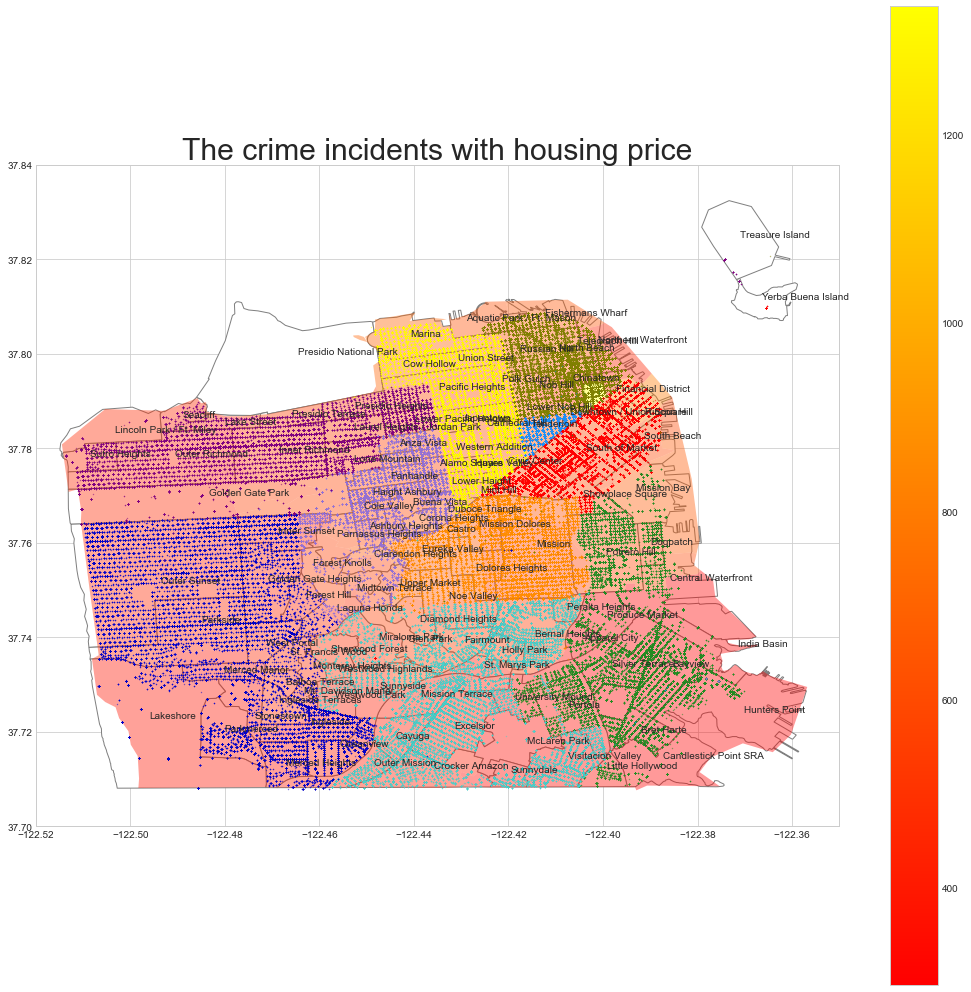

In [36]:
matplotlib.rcParams.update({'font.size': 10})
ax = ngbrs.plot(figsize = (18, 18), edgecolor = "gray", color = "white")

zillow_gpd.plot(ax = ax, column = "MedianSoldPricePerSqft_AllHomes", 
                      cmap='autumn', markersize=3, alpha =0.4, legend = True)

for i,j in zip(c, color):
    exec('crime_' + i + '.plot(ax = ax, marker="*", c="'+j+'", markersize=0.3, alpha=0.5)')

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row['name'], xy = coords, horizontalalignment = "left")
    
# Call add_label() on each row.
ngbrs.apply(add_label, axis = 1)
plt.title("The crime incidents with housing price", fontsize = 30)
plt.show()

In [37]:
parks = pd.read_sql('SELECT * FROM parks',db)
parks_lonlat = [geom.Point(x) for x in zip(parks.Lon, parks.Lat)]
parks = gpd.GeoDataFrame(parks, geometry = parks_lonlat)

In [38]:
parking = pd.read_sql('SELECT * FROM parking',db)
parking_lonlat = [geom.Point(x) for x in zip(parking.Lon, parking.Lat)]
parking = gpd.GeoDataFrame(parking, geometry = parking_lonlat)

In [39]:
school = pd.read_sql('SELECT * FROM schools',db)
school_lonlat = [geom.Point(x) for x in zip(school.Lon, school.Lat)]
school = gpd.GeoDataFrame(school, geometry = school_lonlat)

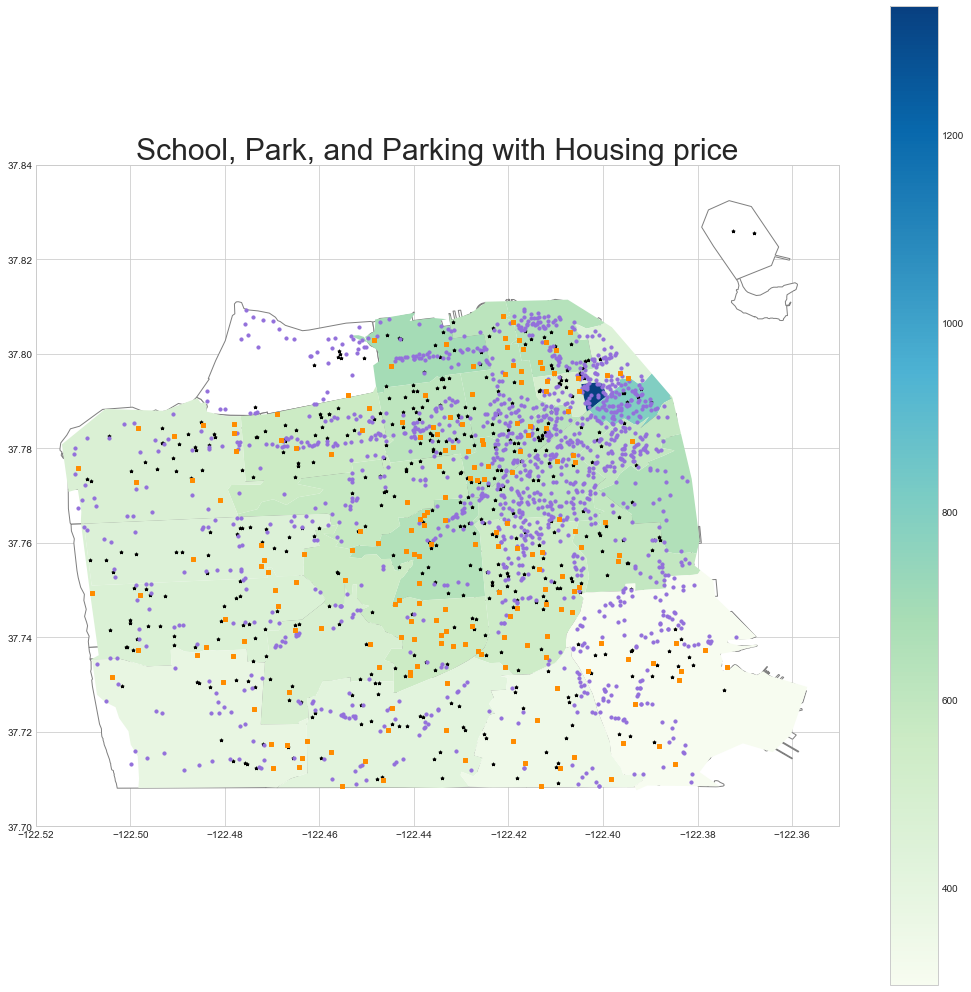

In [40]:
ax = ngbrs.plot(figsize = (18, 18), edgecolor = "gray", color = "white")
#zillow_expensive.plot(ax = ax, column = "MedianSoldPricePerSqft_AllHomes", 
#                      cmap='cool', alpha =0.7)
#zillow_cheap.plot(ax = ax, column = "MedianSoldPricePerSqft_AllHomes", 
#                  cmap = "summer", alpha=0.7)
zillow_gpd.plot(ax = ax, column = "MedianSoldPricePerSqft_AllHomes", 
                  cmap = "GnBu", alpha=1, legend = True)

school.plot(ax = ax, marker='*', color='black', markersize=10)
parking.plot(ax = ax, marker='o', color='mediumpurple', markersize=10)
parks.plot(ax = ax, marker=',', color='darkorange', markersize=10)

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.7, 37.84])

# Given a row, this function gets a point and plots the county name at that point.
#def add_label(row):
#    coords = row.geometry.representative_point().coords[0]
#    ax.annotate(row['name'], xy = coords, horizontalalignment = "left")
    

#ngbrs.apply(add_label, axis = 1)

#matplotlib.rcParams.update({'font.size': 12})
plt.title("School, Park, and Parking with Housing price", fontsize = 30)
plt.show()

__Answer:__

From the above __`Crime rates with Housing Price`__ map, we can find out that the housing price in the highest crime rates area (red plots) is at the middle upper level among San Francisco Neighborings.


Upon the __`School, Park, and Parking with Housing price`__ map, the education and public natrual resources are resonably allocated among residents in San Francisco, which can be concluded by viewing that schools and parks are uniformly distributed among all San Francisco Neighboring without any apparent gathering areas. Opposite to this, parkings are mostly distributed among the middle and northeast of San Francisco, which is probably due to the residental disticts and business districts.

In [41]:
db.close()